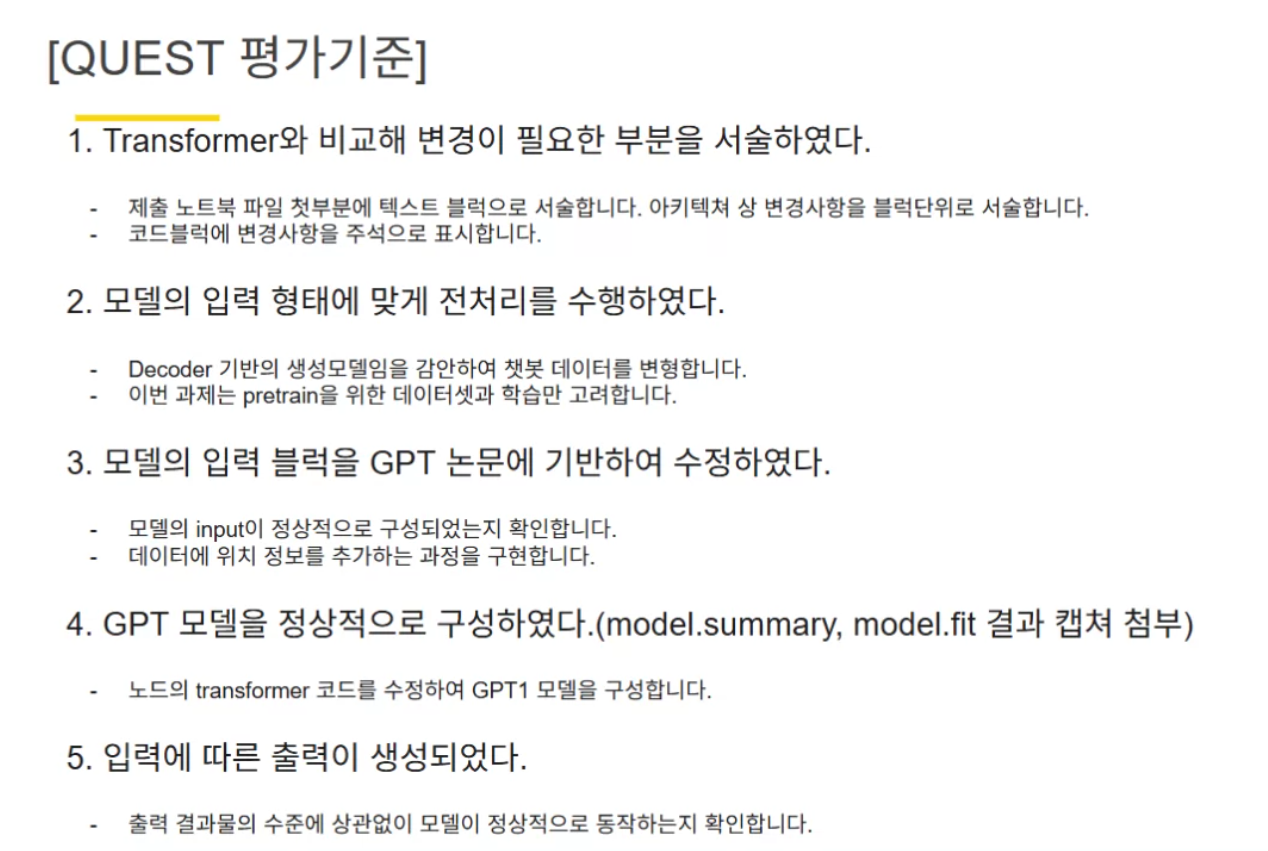

# 변경한 부분
1. 입력 데이터의 Q, A를 하나의 시퀀스로 결합
    1. max_length = 40 → 80
    2. Q와 A를 하나의 시퀀스로 결합
2. 인코더 제거
3. 디코더 블록의 Encoder-Decoder 어텐션 제거  


In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import sentencepiece as spm
from sklearn.model_selection import train_test_split

import math
import os
import re
import urllib.request
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. 데이터 로드

In [38]:
!wget https://github.com/songys/Chatbot_data/raw/master/ChatbotData.csv

--2025-11-05 06:25:32--  https://github.com/songys/Chatbot_data/raw/master/ChatbotData.csv
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv [following]
--2025-11-05 06:25:33--  https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 889842 (869K) [text/plain]
Saving to: ‘ChatbotData.csv’

ChatbotData.csv     100%[===================>] 868.99K  --.-KB/s    in 0.005s  

2025-11-05 06:25:33 (182 MB/s) - ‘ChatbotData.csv’ saved [889842/889842]



In [39]:
data = pd.read_csv("/content/ChatbotData.csv")
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


# 2. 전처리

In [40]:
# 중복, 결측치 확인
print(data.duplicated().sum())
print(data.isna().sum())

0
Q        0
A        0
label    0
dtype: int64


In [41]:
# label 칼럼은 필요 없으므로 제거
del data['label']

In [42]:
def preprocess_sentence(text):
    """
    챗봇 학습용 한국어 전처리 함수
    -------------------------------------------------------
    주요 처리 단계:
    1) 한글, 영어, 숫자, ., ?, !, , , 등만 남기기
    2) 연속 공백 정리
    3) 과도한 반복 문자 정규화 (ㅋㅋㅋㅋ → ㅋㅋ)
    4) 단일 자음/모음 제거 (의미 없는 ㅇ, ㅎ 등)
    5) 단어와 구두점 사이 거리 만들기
    6) 공백 정리
    """

    # 1) 허용되지 않은 문자 제거 (한글, 영어, 숫자, 구두점만 남김)
    text = re.sub(r'[^a-zA-Z가-힣0-9.,?!~\s]', ' ', text)

    # 2) 연속된 공백 정리
    text = re.sub(r'\s+', ' ', text).strip()

    # 3) 반복 문자 정규화 (3번 이상 반복 → 2번)
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)

    # 4) 잡음 정리
    text = re.sub(r'[ㅋㅎㅠㅜ]{2,}', '', text)
    text = re.sub(r'\.{2,}', '.', text)
    text = re.sub(r'~{2,}', '~', text)

    # 5) 단어와 구두점 사이 거리 만들기
    # ex: I am a student." => "I am a student .
    text = re.sub(r"([?.!,])", r" \1 ", text)
    text = re.sub(r'[" "]+', " ", text)

    # 6) 공백 정리
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [43]:
# 샘플 문장 테스트
sample_sentence = "  안녕하세요ㅋㅋㅋㅋ? Hello! I'm a student😊, nice to meet you!"

preprocessed_sentence = preprocess_sentence(sample_sentence)
print(preprocessed_sentence)

안녕하세요 ? Hello ! I m a student , nice to meet you !


In [44]:
# 전처리
data["Q"] = data["Q"].apply(preprocess_sentence)
data["A"] = data["A"].apply(preprocess_sentence)
data.head()

,Q,A
0,12시 땡 !,하루가 또 가네요 .
1,1지망 학교 떨어졌어,위로해 드립니다 .
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠 .
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠 .
4,PPL 심하네,눈살이 찌푸려지죠 .


# 3. SentencePiece 토큰화

In [76]:
# DataFrame의 'Q'와 'A'를 합쳐 하나의 학습용 텍스트로 저장
with open("train_corpus.txt", "w", encoding="utf-8") as f:
    for q, a in zip(data["Q"], data["A"]):
        f.write(str(q).strip() + "\n")
        f.write(str(a).strip() + "\n")

# SentencePiece 모델 학습
spm.SentencePieceTrainer.Train(
    input="/content/train_corpus.txt",
    model_prefix="spm_chatbot",
    vocab_size=2000,
    character_coverage=1.0,
    model_type="bpe",
    max_sentence_length=999999,
    bos_id=1,  # <s>
    eos_id=2,  # </s>
    pad_id=0,  # <pad>
    unk_id=3   # <unk>
)

In [77]:
sp = spm.SentencePieceProcessor()
sp.Load("spm_chatbot.model")

True

In [78]:
# 예제 문장
sentence = "이번 겨울에 여자친구랑 여행 갈거야.  "

sentence = preprocess_sentence(sentence)
print("전처리 후의 문장:", sentence)

# 1. 토크나이징 (subword 단위로 분할)
tokens = sp.encode(sentence, out_type=str)
print("Tokenized:", tokens)

# 2. 인코딩 (서브워드를 정수 ID로 변환)
encoded = sp.encode(sentence, out_type=int)
print("Encoded:", encoded)

# 3. 디코딩 (정수 ID → 원본 문장 복원)
decoded = sp.decode(encoded)
print("Decoded:", decoded)

전처리 후의 문장: 이번 겨울에 여자친구랑 여행 갈거야 .
Tokenized: ['▁이', '번', '▁', '겨', '울', '에', '▁여자친구', '랑', '▁여행', '▁갈', '거', '야', '▁.']
Encoded: [9, 983, 769, 1011, 963, 791, 369, 805, 440, 578, 788, 821, 4]
Decoded: 이번 겨울에 여자친구랑 여행 갈거야 .


# 4. Dataset 구현
- 입력 문장 (question)
- 출력 문장 (answer)  
을 받아서

- ~인코더 입력 (enc_input)~ ### 삭제
- 디코더 입력 (dec_input)
- 디코더 타겟 (target)  
을 만들어주는 역할

In [79]:
# 길이 최대값
max_q_length = data['Q'].apply(lambda x: len(sp.encode(x))).max()
max_a_length = data['A'].apply(lambda x: len(sp.encode(x))).max()

print(max_q_length)
print(max_a_length)


33
42


In [80]:
class ChatBotDataset(Dataset):
    ### max_length = 40 → 60
    def __init__(self, pairs, sp, max_length=60):
        super().__init__()
        self.sp = sp
        self.max_length = max_length
        self.data = []
        ### 특수토큰 id 정의
        self.pad_id = sp.pad_id()

        bos_id = sp.bos_id()
        eos_id = sp.eos_id()

        ### 입력 데이터의 Q, A를 하나의 시퀀스로 결합
        for q_text, a_text in pairs:
            q_ids = sp.EncodeAsIds(q_text)
            a_ids = sp.EncodeAsIds(a_text)

            # 1) Q, A를 하나의 시퀀스로 결합
            # 형식: <s> Q </s> A </s>
            combined_tokens = [bos_id] + q_ids + [eos_id] + a_ids + [eos_id]
            q_len = len([bos_id] + q_ids + [eos_id]) # Q 부분의 길이 (<s>, </s> 포함)

            # 2) 길이 제한
            if len(combined_tokens) > self.max_length + 1:
                continue

            # 3) 고정 길이 패딩
            padding = [self.pad_id] * (self.max_length + 1 - len(combined_tokens))
            combined_tokens += padding

            # 4) input_ids (모델 입력)와 labels (정답) 생성
            # input_ids: <s> Q </s> A
            input_ids = combined_tokens[:-1]
            # labels:    Q </s> A </s>
            labels = combined_tokens[1:]

            # 5) Loss 마스킹: 질문(Q) 부분은 Loss 계산에서 제외
            # 왜? -> 질문 내용이 뭔지 예측하는 건 필요 없음
            # Q 부분의 label을 pad_id로 변경 (CrossEntropyLoss의 ignore_index)
            # <s> Q </s> 까지 마스킹 (q_len - 1 인덱스까지)
            labels[:q_len-1] = [self.pad_id] * (q_len-1)


            self.data.append({
                "input_ids": input_ids,
                "labels": labels
            })

    def __len__(self):
        return len(self.data)

    # Dataset이 [] 인덱싱을 지원하게 해줌
    def __getitem__(self, idx):
        sample = self.data[idx]
        input_ids = torch.tensor(sample["input_ids"], dtype=torch.long)
        labels = torch.tensor(sample["labels"], dtype=torch.long)
        return input_ids, labels ### 반환값이 2개로 변경됨

In [81]:
pairs = list(zip(data["Q"], data["A"]))

# 80%를 Train, 20%를 Validation으로 분리
train_pairs, val_pairs = train_test_split(pairs, test_size=0.2, random_state=42)

print(f"Train: {len(train_pairs)} 쌍")
print(f"Validation: {len(val_pairs)} 쌍")

BATCH_SIZE = 32 # 배치 크기 변수로 지정

train_dataset = ChatBotDataset(train_pairs, sp, max_length=60)
val_dataset = ChatBotDataset(val_pairs, sp, max_length=60)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False) # 검증셋은 섞지 않음

for input_ids, labels in train_dataloader:
    print("Train Input IDs 배치 크기:", input_ids.size())
    print("Train Labels 배치 크기:", labels.size())
    break

Train: 9458 쌍
Validation: 2365 쌍
Train Input IDs 배치 크기: torch.Size([32, 60])
Train Labels 배치 크기: torch.Size([32, 60])


# 5. 모델 구성

## 5.1. Positional encoding

In [82]:
class PositionalEncoding(nn.Module):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        self.position = position

        MAX_SEQ_LEN = 60
        self.pos_encoding = self._build_pos_encoding(position=MAX_SEQ_LEN, d_model=d_model)

    def _get_angles(self, position, i, d_model):
        return 1.0 / (10000.0 ** ((2.0 * (i // 2)) / d_model)) * position

    def _build_pos_encoding(self, position, d_model):
        pos = torch.arange(position, dtype=torch.float32).unsqueeze(1)
        i = torch.arange(d_model, dtype=torch.float32).unsqueeze(0)

        angle_rads = self._get_angles(pos, i, d_model)
        sines = torch.sin(angle_rads[:, 0::2])
        cosines = torch.cos(angle_rads[:, 1::2])

        pos_encoding = torch.zeros(position, d_model)
        pos_encoding[:, 0::2] = sines
        pos_encoding[:, 1::2] = cosines

        pos_encoding = pos_encoding.unsqueeze(0)  # shape: [1, position, d_model]
        return pos_encoding

    def forward(self, x):
        return x + self.pos_encoding[:, :x.size(1), :].to(x.device)

## 5.2. attention

In [83]:
def scaled_dot_product_attention(query, key, value, mask=None):

    # 1) Q와 K의 내적을 통해 score(유사도) 계산
    # key.transpose(-1, -2): (batch_size, heads, depth, seq_len)
    # matmul 결과 shape: (batch_size, heads, seq_len, seq_len)
    matmul_qk = torch.matmul(query, key.transpose(-1, -2))

    # 2) depth에 따라 정규화
    depth = key.size(-1)  # depth = d_model / heads
    logits = matmul_qk / math.sqrt(depth)

    # 3) 마스크가 주어졌다면 -1e9(아주 작은 값)를 더해 소프트맥스에서 제외시키도록 함
    if mask is not None:
        logits = logits + (mask * -1e9)

    # 4) 소프트맥스 계산해 attention weights 생성
    attention_weights = F.softmax(logits, dim=-1)

    # 5) attention weights와 value의 내적
    output = torch.matmul(attention_weights, value)

    return output, attention_weights

In [84]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        # d_model은 num_heads로 나누어떨어져야 함
        assert d_model % num_heads == 0

        self.depth = d_model // num_heads

        # 파이토치에서 Dense는 nn.Linear로 대응
        self.query_dense = nn.Linear(d_model, d_model)
        self.key_dense = nn.Linear(d_model, d_model)
        self.value_dense = nn.Linear(d_model, d_model)

        self.out_dense = nn.Linear(d_model, d_model)

    def split_heads(self, x, batch_size):
        """
        x: (batch_size, seq_len, d_model)
        => (batch_size, num_heads, seq_len, depth) 형태로 변환
        """
        x = x.view(batch_size, -1, self.num_heads, self.depth)
        x = x.permute(0, 2, 1, 3)  # (batch_size, num_heads, seq_len, depth)
        return x

    def forward(self, query, key, value, mask=None):
        """
        query, key, value: (batch_size, seq_len, d_model)
        mask: (batch_size, 1, seq_len, seq_len) 등으로 broadcast 가능하도록 구성
        """
        batch_size = query.size(0)

        # Q, K, V에 각각 Linear 적용
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # Head 분할
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션
        # _ : 두 번째 반환하는 변수(attention weight)는 안 쓰겠다.
        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)

        # (batch_size, num_heads, seq_len, depth) -> (batch_size, seq_len, num_heads, depth)
        scaled_attention = scaled_attention.permute(0, 2, 1, 3).contiguous()

        # 다시 (batch_size, seq_len, d_model)로 합치기
        concat_attention = scaled_attention.view(batch_size, -1, self.d_model)

        # 최종 Dense
        output = self.out_dense(concat_attention)
        return output

## 5.3. 마스킹

### 5.3.1. padding masking

In [85]:
def create_padding_mask(x):
    # x == 0 위치를 찾아 float형 1로 변환
    mask = (x == 0).float()
    # (batch_size, seq_len) -> (batch_size, 1, 1, seq_len)
    mask = mask.unsqueeze(1).unsqueeze(2)
    return mask

### 5.3.2. look-ahead masking
다음 단어 가리기

In [86]:
def create_look_ahead_mask(x):
    seq_len = x.size(1)

    # (seq_len, seq_len) 크기의 하삼각 행렬(tril) 생성 후 1에서 빼서
    # 상삼각이 1, 하삼각(자기 자신 포함)이 0이 되도록 설정
    # => 미래 토큰(자신 인덱스보다 큰 위치) 마스킹
    look_ahead_mask = 1 - torch.tril(torch.ones((seq_len, seq_len)))

    # 패딩 마스크 생성 (shape: (batch_size, 1, 1, seq_len))
    padding_mask = create_padding_mask(x)

    # look_ahead_mask: (seq_len, seq_len) -> (1, seq_len, seq_len)
    look_ahead_mask = look_ahead_mask.unsqueeze(0)
    # -> (1, seq_len, seq_len) -> (1, 1, seq_len, seq_len)
    look_ahead_mask = look_ahead_mask.unsqueeze(1)
    look_ahead_mask = look_ahead_mask.to(x.device)

    # look-ahead 마스크와 패딩 마스크를 합성 (둘 중 하나라도 1이면 마스킹)
    # 최종 shape은 브로드캐스팅으로 (batch_size, 1, seq_len, seq_len)
    combined_mask = torch.max(look_ahead_mask, padding_mask)
    return combined_mask

## ~5.4. 인코더~ -> 삭제

class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)  # 이전에 구현한 MHA
        self.dropout1 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)

        # 피드포워드 부분 (Dense -> ReLU -> Dense)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, d_model)
        )
        self.dropout2 = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(d_model, eps=1e-6)

    def forward(self, x, mask=None):
        # (1) 멀티 헤드 어텐션 (셀프 어텐션)
        attn_output = self.mha(x, x, x, mask)  # (batch_size, seq_len, d_model)
        attn_output = self.dropout1(attn_output)
        out1 = self.norm1(x + attn_output)     # 잔차 연결 + LayerNorm

        # (2) 피드포워드 신경망
        ffn_output = self.ffn(out1)            # (batch_size, seq_len, d_model)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.norm2(out1 + ffn_output)   # 잔차 연결 + LayerNorm

        return out2

class Encoder(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,
                 ff_dim,
                 d_model,
                 num_heads,
                 dropout=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model

        # (1) 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, d_model)

        # (2) 포지셔널 인코딩
        self.pos_encoding = PositionalEncoding(position=vocab_size, d_model=d_model)

        self.dropout = nn.Dropout(dropout)

        # (3) EncoderLayer 쌓기
        self.enc_layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, mask=None):
        # (1) 임베딩 & sqrt(d_model)로 스케일링
        x = self.embedding(x) * math.sqrt(self.d_model)

        # (2) 포지셔널 인코딩 적용 + 드롭아웃
        x = self.pos_encoding(x)  # shape: (batch_size, seq_len, d_model)
        x = self.dropout(x)

        # (3) num_layers만큼 쌓아올린 EncoderLayer 통과
        for layer in self.enc_layers:
            x = layer(x, mask)

        return x

## 5.5. 디코더

In [87]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super(DecoderLayer, self).__init__()

        # 첫 번째 서브 레이어 (디코더 내부 셀프 어텐션)
        self.self_mha = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)

        ### 두 번째 서브 레이어 (인코더-디코더 어텐션) -> 삭제
        #self.encdec_mha = MultiHeadAttention(d_model, num_heads)
        #self.norm2 = nn.LayerNorm(d_model, eps=1e-6)

        # 세 번째 서브 레이어 (피드포워드 네트워크)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_dim),  # Dense(units=ff_dim)
            nn.ReLU(),                   # activation='relu'
            nn.Linear(ff_dim, d_model)   # Dense(units=d_model)
        )
        self.norm3 = nn.LayerNorm(d_model, eps=1e-6)

        # 드롭아웃
        self.dropout1 = nn.Dropout(dropout)
        #self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, x, look_ahead_mask=None):
        # 1) 셀프 어텐션 (디코더 내부)
        # x, x, x 는 Q, K, V를 의미함
        self_attn_out = self.self_mha(x, x, x, mask=look_ahead_mask)
        self_attn_out = self.dropout1(self_attn_out)
        out1 = self.norm1(x + self_attn_out)  # 잔차 연결 + LayerNorm

        ### 2) 인코더-디코더 어텐션 -> 삭제
        # out1 = Q, enc_outputs = K & V
        #encdec_attn_out = self.encdec_mha(out1, enc_outputs, enc_outputs, mask=padding_mask)
        #encdec_attn_out = self.dropout2(encdec_attn_out)
        #out2 = self.norm2(out1 + encdec_attn_out)  # 잔차 연결 + LayerNorm

        # 3) 피드포워드 (Dense -> ReLU -> Dense)
        ffn_out = self.ffn(out1)
        ffn_out = self.dropout3(ffn_out)
        out3 = self.norm3(out1 + ffn_out)  # 잔차 연결 + LayerNorm

        return out3

In [88]:
class Decoder(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,
                 ff_dim,
                 d_model,
                 num_heads,
                 dropout=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model

        # (1) 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, d_model)

        # (2) 포지셔널 인코딩
        # 실제 학습 시에는 최대 시퀀스 길이에 맞추어 쓰기도 함
        self.pos_encoding = PositionalEncoding(position=60, d_model=d_model)

        self.dropout = nn.Dropout(dropout)

        # (3) DecoderLayer 쌓기
        self.dec_layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, look_ahead_mask=None):
        # (1) 임베딩 + sqrt(d_model)로 스케일링
        x = self.embedding(x) * math.sqrt(self.d_model)

        # (2) 포지셔널 인코딩 + 드롭아웃
        x = self.pos_encoding(x)    # (batch_size, tgt_seq_len, d_model)
        x = self.dropout(x)

        # (3) num_layers만큼 쌓인 DecoderLayer 통과
        for layer in self.dec_layers:
            # enc_outputs와 padding_mask 제거
            # x = layer(x, enc_outputs, look_ahead_mask, padding_mask)
            x = layer(x, look_ahead_mask=look_ahead_mask)

        return x

## 5.6. transformer

In [89]:
class Transformer(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,      # 인코더/디코더 층 수
                 units,           # feed-forward 네트워크의 중간 차원(ff_dim)
                 d_model,         # 임베딩 및 내부 표현 차원
                 num_heads,       # 멀티헤드 어텐션의 헤드 수
                 dropout=0.1):
        super(Transformer, self).__init__()

        ### 인코더 -> 제거
        #self.encoder = Encoder(
        #    vocab_size=vocab_size,
        #    num_layers=num_layers,
        #    ff_dim=units,
        #    d_model=d_model,
        #    num_heads=num_heads,
        #    dropout=dropout
        #)

        # 디코더
        self.decoder = Decoder(
            vocab_size=vocab_size,
            num_layers=num_layers,
            ff_dim=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout
        )

        # 최종 출력층: (d_model) -> (vocab_size)
        self.final_linear = nn.Linear(d_model, vocab_size)

    def forward(self, inputs, dec_inputs=None):
        ### 1) 인코더 패딩 마스크 생성 -> 삭제
        # 패딩 토큰 무시하기 위함
        #enc_padding_mask = create_padding_mask(inputs)

        # 2) 디코더 look-ahead + 패딩 마스크
        # 미래 단어 가리기
        look_ahead_mask = create_look_ahead_mask(inputs)  ### dec_inputs 대신 inputs 사용

        ### 3) 디코더에서 인코더 출력 쪽을 마스킹할 때 쓸 패딩 마스크 -> 삭제
        # 패딩 토큰 무시
        #dec_padding_mask = create_padding_mask(inputs)

        ### 4) 인코더 수행 -> 삭제
        #enc_outputs = self.encoder(
        #    x=inputs,
        #    mask=enc_padding_mask
        #)  # shape: (batch_size, src_seq_len, d_model)

        ### 5) 디코더 수행 -> enc_outputs, dec_padding_mask 제거
        dec_outputs = self.decoder(
            x=inputs,
            look_ahead_mask=look_ahead_mask,
        )

        # 6) 최종 Dense (vocab_size)
        logits = self.final_linear(dec_outputs)
        return logits

In [90]:
# 하이퍼파라미터 설정
NUM_LAYERS = 3     # 인코더/디코더 층 수
D_MODEL = 256      # 임베딩 및 내부 표현 차원
NUM_HEADS = 8      # 멀티헤드 어텐션에서의 헤드 수
UNITS = 1024       # 피드포워드 신경망의 은닉 차원
DROPOUT = 0.1      # 드롭아웃 비율
VOCAB_SIZE = 2000  # 단어 집합 크기

# 모델 생성
model = Transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT
)

print(model)

Transformer(
  (decoder): Decoder(
    (embedding): Embedding(2000, 256)
    (pos_encoding): PositionalEncoding()
    (dropout): Dropout(p=0.1, inplace=False)
    (dec_layers): ModuleList(
      (0-2): 3 x DecoderLayer(
        (self_mha): MultiHeadAttention(
          (query_dense): Linear(in_features=256, out_features=256, bias=True)
          (key_dense): Linear(in_features=256, out_features=256, bias=True)
          (value_dense): Linear(in_features=256, out_features=256, bias=True)
          (out_dense): Linear(in_features=256, out_features=256, bias=True)
        )
        (norm1): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
        (ffn): Sequential(
          (0): Linear(in_features=256, out_features=1024, bias=True)
          (1): ReLU()
          (2): Linear(in_features=1024, out_features=256, bias=True)
        )
        (norm3): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout3): Dropout(p=0.1

# 6. 모델 학습

## 6.1. 손실함수 & 학습률

In [91]:
# 손실 함수
loss_function = nn.CrossEntropyLoss(ignore_index=sp.pad_id())

# Learning rate
## Custom Learning rate Scheduling
## 모델 학습 초기에는 lr 급격히 높였다가,
## 이후 train step에서 천천히 낮추며 안정적으로 수렴하게 하는 고급 기법
def get_lr_lambda(d_model, warmup_steps=4000):
    d_model = float(d_model)
    def lr_lambda(step):
        # step은 0부터 시작하므로 +1로 보정
        step = step + 1
        return (d_model ** -0.5) * min(step ** -0.5, step * (warmup_steps ** -1.5))
    return lr_lambda

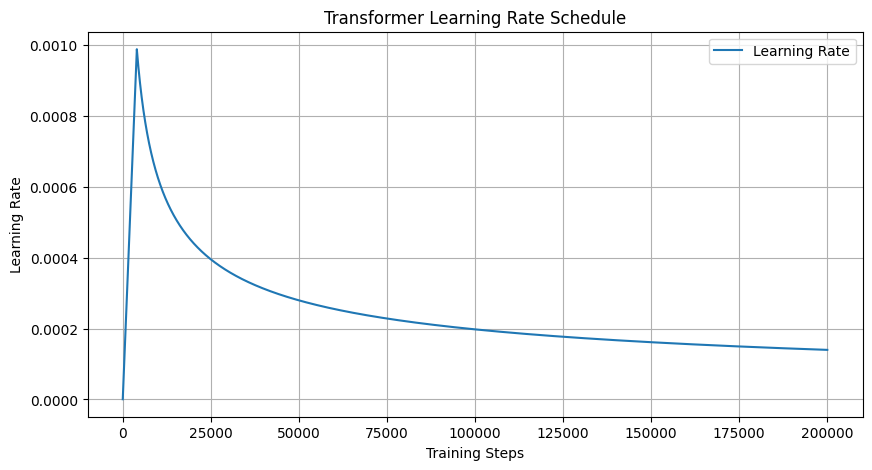

In [92]:
# 하이퍼파라미터 설정
d_model = 256
warmup_steps = 4000
total_steps = 200000  # 총 학습 스텝

# 학습률 스케줄 시각화
steps = np.arange(1, total_steps + 1)
learning_rates = [get_lr_lambda(d_model, warmup_steps)(step) for step in steps]

# 그래프 출력
plt.figure(figsize=(10, 5))
plt.plot(steps, learning_rates, label="Learning Rate")
plt.xlabel("Training Steps")
plt.ylabel("Learning Rate")
plt.title("Transformer Learning Rate Schedule")
plt.legend()
plt.grid(True)
plt.show()

## 6.2. 모델 컴파일

In [93]:
# Optimizer 정의
optimizer = optim.Adam(model.parameters(), betas=(0.9, 0.98), eps=1e-9)

# Scheduler 정의
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=get_lr_lambda(D_MODEL, warmup_steps=4000))

def accuracy_function(y_pred, y_true, pad_id=0):
    """
    y_pred: (batch_size, seq_len, vocab_size)
    y_true: (batch_size, seq_len)
    """
    preds = y_pred.argmax(dim=-1)  # (batch_size, seq_len)
    mask = (y_true != pad_id)
    correct = (preds == y_true) & mask
    acc = correct.float().sum() / mask.float().sum()
    return acc

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

AcceleratorError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


## 6.3. train 함수 정의

In [ ]:
def train_step(model, batch, optimizer, loss_function, device):
    model.train()
    ### 배치 데이터 변경
    input_ids, labels = [x.to(device) for x in batch]

    optimizer.zero_grad()

    # 모델 포워드 패스
    logits = model(input_ids)  # (batch_size, seq_len, vocab_size)

    # Loss 계산 (패딩 토큰 무시)
    loss = loss_function(logits.permute(0, 2, 1), labels)  # (batch_size, vocab_size, seq_len) 필요

    # Backpropagation
    loss.backward()
    optimizer.step()

    return loss.item(), accuracy_function(logits, labels, pad_id=sp.pad_id())

def evaluate_step(model, batch, loss_function, device):
    model.eval()  # 평가 모드로 설정 (Dropout 비활성화)

    input_ids, labels = [x.to(device) for x in batch]

    with torch.no_grad(): # 그래디언트 계산 비활성화
        logits = model(input_ids)
        loss = loss_function(logits.permute(0, 2, 1), labels)
        acc = accuracy_function(logits, labels, pad_id=sp.pad_id())

    return loss.item(), acc

def train(model, train_loader, val_loader, optimizer, loss_function, scheduler, num_epochs, device):
    model.to(device)

    # 조기 종료(Early Stopping) 설정
    best_valid_loss = float('inf')  # 최고 성능(가장 낮은 손실)을 저장할 변수
    patience = 7  # 7 에폭 동안 성능 개선이 없으면 중단
    patience_counter = 0  # 카운터
    model_save_path = 'best_gpt_model.pt' # 최고 모델 저장 경로

    print("--- 학습 시작 ---")

    for epoch in range(num_epochs):

        # --- 1. 학습 (Train) ---
        model.train() # 학습 모드
        total_train_loss, total_train_acc = 0, 0

        for step, batch in enumerate(train_loader):
            loss, acc = train_step(model, batch, optimizer, loss_function, device)
            total_train_loss += loss
            total_train_acc += acc

            if step % 100 == 0:
                print(f"[Epoch {epoch+1:02d}, Step {step:03d}] Train Loss: {loss:.4f}, Train Acc: {acc:.4f}")

            scheduler.step()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_acc = total_train_acc / len(train_loader)

        # --- 2. 검증 (Validation) ---
        total_valid_loss, total_valid_acc = 0, 0

        # evaluate_step 함수 사용
        for batch in val_loader:
            loss, acc = evaluate_step(model, batch, loss_function, device)
            total_valid_loss += loss
            total_valid_acc += acc

        avg_valid_loss = total_valid_loss / len(val_loader)
        avg_valid_acc = total_valid_acc / len(val_loader)

        print(f"--- Epoch {epoch+1:02d} 완료 ---")
        print(f"Avg Train Loss: {avg_train_loss:.4f}, Avg Train Acc: {avg_train_acc:.4f}")
        print(f"Avg Valid Loss: {avg_valid_loss:.4f}, Avg Valid Acc: {avg_valid_acc:.4f}")

        # --- 3. 조기 종료 (Early Stopping) 체크 ---
        if avg_valid_loss < best_valid_loss:
            best_valid_loss = avg_valid_loss
            patience_counter = 0
            # 최고 성능 모델 저장
            torch.save(model.state_dict(), model_save_path)
            print(f"성능 개선! 최고 모델 저장됨 (Loss: {best_valid_loss:.4f})")
        else:
            patience_counter += 1
            print(f"성능 개선 없음 ({patience_counter}/{patience})")
            if patience_counter >= patience:
                print(f"--- 조기 종료 (Epoch {epoch+1}) ---")
                break

    print(f"--- 학습 종료 (최고 Valid Loss: {best_valid_loss:.4f}) ---")
    # 최고 성능 모델 다시 로드
    model.load_state_dict(torch.load(model_save_path))

In [ ]:
%%time

train(
    model=model,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    optimizer=optimizer,
    loss_function=loss_function,
    scheduler=scheduler,
    num_epochs=500,
    device=device
)

# 7. 챗봇 테스트
예측(inference) 단계는 기본적으로 다음과 같은 과정을 거칩니다.

1. 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.
2. 입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가한다.
3. 패딩 마스킹과 룩 어헤드 마스킹을 계산한다.
4. 디코더는 입력 시퀀스로부터 다음 단어를 예측한다.
5. 디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.
6. END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.  


위의 과정을 모두 담은 decoder_inference() 함수를 만듭니다.



In [ ]:
def decoder_inference(model, sentence, tokenizer, device='cuda'):
    START_TOKEN = tokenizer.bos_id()
    END_TOKEN = tokenizer.eos_id()
    MAX_LENGTH = 60 # 답변의 최대 길이


    # 전처리
    sentence = preprocess_sentence(sentence)

    ### 인코더 입력: [START] + 인코딩 + [END] -> 삭제
    ### 인코더 입력 대신, 프롬프트(Q)를 디코더의 초기 입력으로 사용
    input_ids = [START_TOKEN] + tokenizer.encode(sentence) + [END_TOKEN]
    dec_input = torch.tensor([input_ids], dtype=torch.long, device=device)

    model.eval()  # 모델 평가 모드
    with torch.no_grad():
        for i in range(MAX_LENGTH):
            ### 모델 forward: (dec_input) -> (batch_size=1, seq_len, vocab_size)
            logits = model(dec_input)

            # 마지막 타임스텝의 예측만 추출: shape (1, 1, vocab_size)
            # logits[:, -1, :] -> (1, vocab_size)
            last_step_logits = logits[:, -1, :]

            # argmax로 가장 높은 확률의 토큰 선택
            predicted_id = torch.argmax(last_step_logits, dim=-1)  # shape: (1,)

            # 종료 토큰이면 중단
            if predicted_id.item() == END_TOKEN:
                break

            # 디코더 입력(dec_input)에 예측 토큰을 이어붙임
            predicted_id = predicted_id.unsqueeze(0)  # shape (1,1)
            dec_input = torch.cat([dec_input, predicted_id], dim=1)

    ### 최종 결과 (input_ids 제외, 즉 Q 부분 제외)
    output_sequence = dec_input.squeeze(0).tolist()
    output_sequence = output_sequence[len(input_ids):] # 생성된 A 부분만 추출

    return output_sequence

In [ ]:
def sentence_generation(model, sentence, tokenizer, device='cuda'):
    # 디코더 인퍼런스 -> 예측된 토큰 시퀀스
    output_seq = decoder_inference(model, sentence, tokenizer, device=device)

    ### output_seq[1:] -> output_seq (inference 함수에서 이미 <s> 제거됨)
    predicted_sentence = tokenizer.decode(
        [token for token in output_seq if token < tokenizer.GetPieceSize()]
    )

    print("입력 :", sentence)
    print("출력 :", predicted_sentence)
    return predicted_sentence

In [ ]:
model.load_state_dict(torch.load('best_gpt_model.pt', map_location=device))
model.to(device)
model.eval() # <--- 평가 모드로 설정

# 테스트할 문장 리스트 정의
test_sentences = [
    "이번 겨울에 여자친구랑 일본 여행 갈거야",
    "오늘 점심 뭐 먹지?",
    "공부하기 너무 싫다",
    "요즘 너무 행복해",
]

print("--- 챗봇 테스트 시작 ---")

# for 루프를 사용해 각 문장을 모델에 입력
for sentence in test_sentences:
    sentence_generation(model, sentence, sp, device)
    print("-" * 30) # 답변 구분을 위한 라인

print("--- 챗봇 테스트 종료 ---")

1차 시도:  
- NUM_LAYERS = 3    
- D_MODEL = 256      
- UNITS = 1024    
- DROPOUT = 0.1      
- VOCAB_SIZE = 8000  
- num_epochs = 50  

Epoch 50 Completed - Avg Loss: 6.0493, Avg Acc: 0.2922  
```
입력 : 이번 겨울에 여자친구랑 일본 여행 갈거야
출력 :
------------------------------
입력 : 오늘 점심 뭐 먹지?
출력 :
------------------------------
입력 : 공부하기 너무 싫다
출력 :
------------------------------
입력 : 요즘 너무 행복해
출력 :
------------------------------
```
<br>


2차 시도:  
- num_epochs = 50 → 500  

Avg Valid Loss: 5.7465, Avg Valid Acc: 0.3036  
vocab size를 줄이기 위해 200 에폭에서 멈췄다.
```
--- 챗봇 테스트 시작 ---
입력 : 이번 겨울에 여자친구랑 일본 여행 갈거야
출력 : 잘 .
------------------------------
입력 : 오늘 점심 뭐 먹지?
출력 : 잘 .
------------------------------
입력 : 공부하기 너무 싫다
출력 : 잘
------------------------------
입력 : 요즘 너무 행복해
출력 : 좋은 거예요 .
------------------------------
--- 챗봇 테스트 종료 ---
```
<br>

3차 시도:  
- VOCAB_SIZE = 8000 → 2000



model.summary:  


model.fit:  
